In [ ]:
# 1. Importación de librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# 2. Carga y preparación inicial de datos
def cargar_datos(ruta_archivo):
    """Carga el dataset y realiza la limpieza inicial."""
    df = pd.read_csv(ruta_archivo)
    return df

# 3. Preprocesamiento de datos
def preparar_datos(df):
    """Prepara y limpia los datos para el análisis."""
    # Filtrar solo vuelos de salida desde 2015
    df_salidas = df[
        (df['OPER_2'] == 'SALEN') & 
        (df['Año'] >= 2015) & 
        (df['PASAJEROS'] != 0)
    ]
    
    # Seleccionar columnas relevantes
    columnas = [
        "Año", "Mes", "Operador", "ORIG_1", "DEST_1",
        "OPER_2", "NAC", "PAX_LIB", "PASAJEROS", "CAR_LIB",
        "CARGA (Ton)", "CORREO", "Distancia"
    ]
    df_salidas = df_salidas[columnas].drop_duplicates()
    
    # Crear características temporales
    df_salidas['Fecha'] = pd.to_datetime(
        df_salidas['Año'].astype(str) + '-' + 
        df_salidas['Mes'].astype(str) + '-01'
    )
    
    # Mapear temporadas
    temporadas = {
        12:'Invierno', 1:'Invierno', 2:'Invierno',
        3:'Primavera', 4:'Primavera', 5:'Primavera',
        6:'Verano', 7:'Verano', 8:'Verano',
        9:'Otoño', 10:'Otoño', 11:'Otoño'
    }
    df_salidas['Temporada'] = df_salidas['Mes'].map(temporadas)
    
    return df_salidas

# 4. Análisis temporal
def crear_datos_mensuales(df_salidas):
    """Crea agregaciones mensuales y features para predicción."""
    df_mensual = df_salidas.groupby(['Fecha'])[['PASAJEROS']].sum().reset_index()
    df_mensual['Mes_Numero'] = df_mensual.index + 1
    df_mensual['Año'] = df_mensual['Fecha'].dt.year
    df_mensual['Mes'] = df_mensual['Fecha'].dt.month
    df_mensual['prev_month_passengers'] = df_mensual['PASAJEROS'].shift(1).fillna(df_mensual['PASAJEROS'].mean())
    df_mensual['is_holiday'] = df_mensual['Mes'].isin([7, 8, 12]).astype(int)
    df_mensual['quarter'] = (df_mensual['Mes'] - 1) // 3 + 1
    
    return df_mensual

# 5. Visualizaciones
def visualizar_tendencias(df_mensual, df_salidas):
    """Genera gráficos de análisis temporal."""
    fig, axes = plt.subplots(2, 1, figsize=(12, 8))
    
    # Tendencia temporal
    sns.lineplot(data=df_mensual, x='Fecha', y='PASAJEROS', ax=axes[0])
    axes[0].set_title('Tendencia de Pasajeros por Mes')
    
    # Distribución por temporada
    sns.boxplot(data=df_salidas, x='Temporada', y='PASAJEROS', ax=axes[1])
    axes[1].set_title('Distribución de Pasajeros por Temporada')
    
    plt.tight_layout()
    plt.show()

# 6. Modelo predictivo
def entrenar_modelo(df_mensual):
    """Entrena y evalúa el modelo de Random Forest."""
    X = df_mensual[['Mes_Numero', 'Mes', 'Año', 'is_holiday', 'quarter', 'prev_month_passengers']]
    y = df_mensual['PASAJEROS']
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
    
    modelo = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
    modelo.fit(X_train, y_train)
    
    return modelo, scaler, X.columns

# 7. Ejecución principal
if __name__ == "__main__":
    # Cargar datos
    df = cargar_datos("BD_Trafico_aereo.csv")
    
    # Preparar datos
    df_salidas = preparar_datos(df)
    df_mensual = crear_datos_mensuales(df_salidas)
    
    # Visualizar tendencias
    visualizar_tendencias(df_mensual, df_salidas)
    
    # Entrenar modelo
    modelo, scaler, feature_names = entrenar_modelo(df_mensual)
    
    print("Análisis completado exitosamente!")

In [2]:
import pandas as pd
import numpy as np

#leer el archivo CSV
df = pd.read_csv("BD_Trafico_aereo.csv")

C:\Users\Francisco Rosas\AppData\Local\Temp\ipykernel_14464\2058061699.py:5: DtypeWarning: Columns (22,23) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("BD_Trafico_aereo.csv")


In [3]:
df.head()

,Año,Mes,Cod_Operador,Operador,Grupo,ORIG_1,DEST_1,ORIG_1_N,DEST_1_N,ORIG_1_PAIS,...,ORIG_2_PAIS,DEST_2_PAIS,OPER_2,NAC,PAX_LIB,PASAJEROS,CAR_LIB,CARGA (Ton),CORREO,Distancia
0,1984,1,31,FAST AIR,FAST AIR,ARI,NYC,ARICA,NEW YORK,CHILE,...,CHILE,ESTADOS UNIDOS,SALEN,INTERNACIONAL,0.0,0.0,0,13.0,0.0,7.369
1,1984,1,31,FAST AIR,FAST AIR,SCL,BOG,SANTIAGO,BOGOTA,CHILE,...,CHILE,COLOMBIA,SALEN,INTERNACIONAL,0.0,0.0,0,29.0,0.0,4.247
2,1984,1,31,FAST AIR,FAST AIR,SCL,MIA,SANTIAGO,MIAMI,CHILE,...,CHILE,ESTADOS UNIDOS,SALEN,INTERNACIONAL,0.0,0.0,0,34.0,0.0,6.653
3,1984,1,31,FAST AIR,FAST AIR,SCL,PTY,SANTIAGO,CIUDAD DE PANAMÁ,CHILE,...,CHILE,PANAMA,SALEN,INTERNACIONAL,0.0,0.0,0,0.0,0.0,4.805
4,1984,1,31,FAST AIR,FAST AIR,SCL,SAO,SANTIAGO,SAO PAULO,CHILE,...,CHILE,BRASIL,SALEN,INTERNACIONAL,0.0,0.0,0,62.0,0.0,2.585


In [16]:
#filtrar los datos para obtener solo las salidas desde 2015
#seleccionar las columnas relevantes
df_salidas = df[df['OPER_2'] == 'SALEN'] 
df_salidas = df_salidas[df_salidas['Año']>=2015]
df_salidas = df_salidas[df_salidas["PASAJEROS"] != 0]


In [17]:
df_salidas = df_salidas[
    [
        "Año", "Mes","Operador", "ORIG_1", "DEST_1",
        "OPER_2", "NAC", "PAX_LIB", "PASAJEROS", "CAR_LIB",
        "CARGA (Ton)", "CORREO", "Distancia"
    ]
]

In [20]:

# Verificar valores nulos
#print("Valores nulos por columna:")
#print(df_salidas.isnull().sum())

# Eliminar duplicados si existen
df_salidas = df_salidas.drop_duplicates()

# Convertir tipos de datos
df_salidas['Año'] = df_salidas['Año'].astype(int)
df_salidas['Mes'] = df_salidas['Mes'].astype(int)

# Crear características temporales
df_salidas['Fecha'] = pd.to_datetime(df_salidas['Año'].astype(str) + '-' + df_salidas['Mes'].astype(str) + '-01')
df_salidas['Temporada'] = df_salidas['Mes'].map({12:'Invierno', 1:'Invierno', 2:'Invierno',
                                                3:'Primavera', 4:'Primavera', 5:'Primavera',
                                                6:'Verano', 7:'Verano', 8:'Verano',
                                                9:'Otoño', 10:'Otoño', 11:'Otoño'})



In [21]:

# Agregar datos por mes para predicción
df_mensual = df_salidas.groupby(['Fecha'])[['PASAJEROS']].sum().reset_index()

# Crear características de tendencia
df_mensual['Mes_Numero'] = df_mensual.index + 1
df_mensual['Año'] = df_mensual['Fecha'].dt.year
df_mensual['Mes'] = df_mensual['Fecha'].dt.month


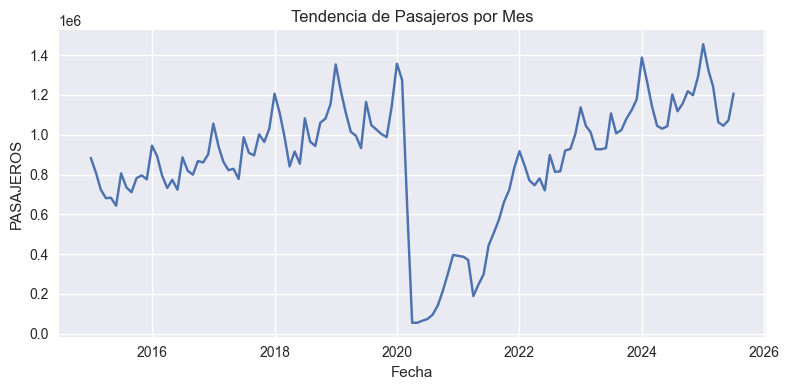

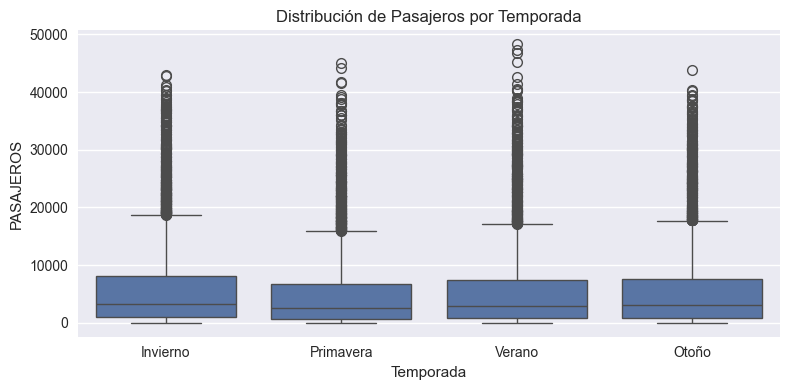

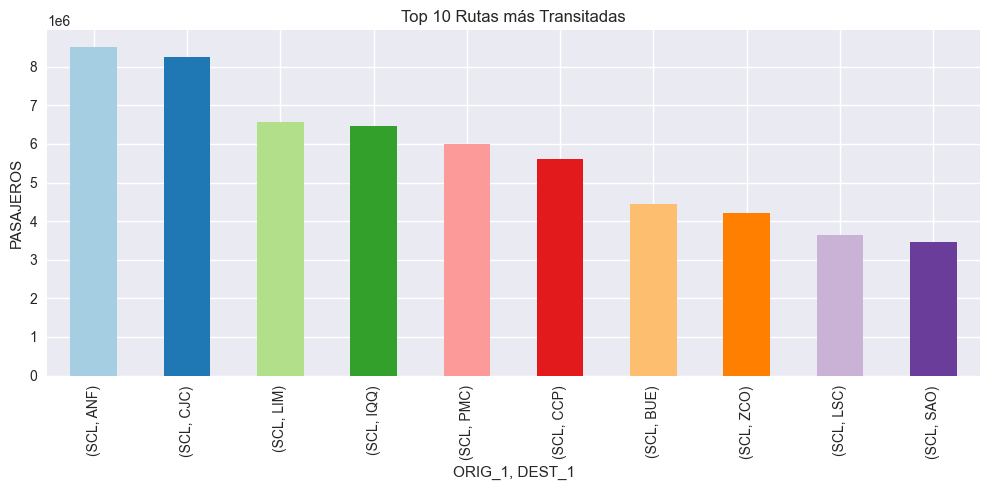

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# Tendencia temporal
plt.figure(figsize=(8, 4))
sns.lineplot(data=df_mensual, x='Fecha', y='PASAJEROS')
plt.title('Tendencia de Pasajeros por Mes')
plt.tight_layout()
plt.show()

# Pasajeros por temporada
plt.figure(figsize=(8, 4))
sns.boxplot(data=df_salidas, x='Temporada', y='PASAJEROS')
plt.title('Distribución de Pasajeros por Temporada')
plt.tight_layout()
plt.show()

# Top 10 rutas con paleta de colores cálida
plt.figure(figsize=(10, 5))
colors = sns.color_palette("Paired", len(top_rutas))
top_rutas.plot(kind='bar', color=colors)
plt.title('Top 10 Rutas más Transitadas')
plt.xlabel('ORIG_1, DEST_1')
plt.ylabel('PASAJEROS')
plt.tight_layout()
plt.show()


In [32]:
#realizar un modelo predictivo simple
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

#preparar datos para el modelo
X = df_mensual[['Mes_Numero', 'Mes']]
y = df_mensual['PASAJEROS']

#dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#entrenar el modelo
modelo = LinearRegression()
modelo.fit(X_train, y_train)

#evaluar el modelo
y_pred = modelo.predict(X_test)
print(f"r2 Score: {r2_score(y_test, y_pred)}")
print(f"root mean squared error: {np.sqrt(mean_squared_error(y_test, y_pred))}")


r2 Score: 0.10908228490450345
root mean squared error: 231287.90213319755


Métricas del modelo:
R² Score: 0.748
RMSE: 122918.62


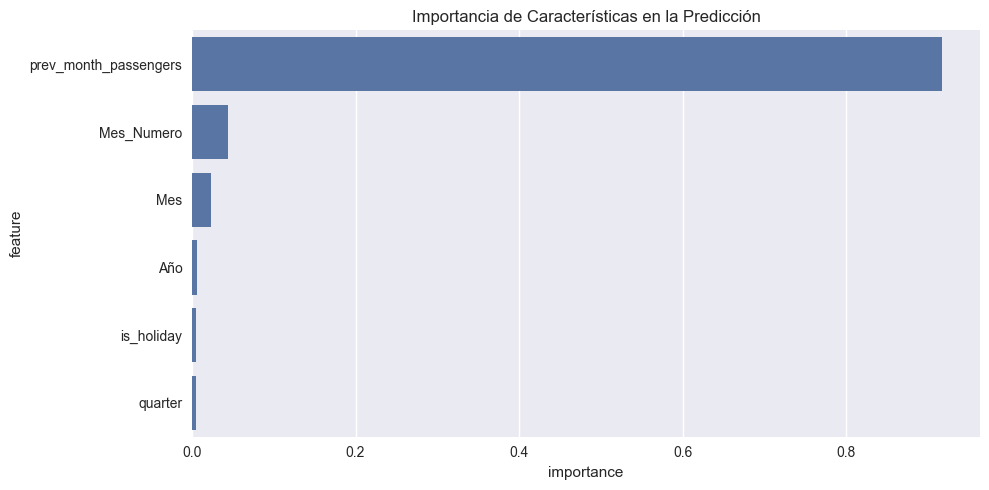


Predicciones para los próximos 3 meses:
Mes 1: 1,138,204 pasajeros
Mes 2: 1,147,549 pasajeros
Mes 3: 1,166,457 pasajeros


In [35]:
# Importar bibliotecas adicionales
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

# Crear características más relevantes para la predicción
df_mensual['prev_month_passengers'] = df_mensual['PASAJEROS'].shift(1).fillna(df_mensual['PASAJEROS'].mean())
df_mensual['is_holiday'] = df_mensual['Mes'].isin([7, 8, 12]).astype(int)  # Temporada alta
df_mensual['quarter'] = (df_mensual['Mes'] - 1) // 3 + 1  # Trimestre del año

# Preparar features
X = df_mensual[[
    'Mes_Numero', 
    'Mes', 
    'Año', 
    'is_holiday',
    'quarter',
    'prev_month_passengers'
]]
y = df_mensual['PASAJEROS']

# Normalizar datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dividir datos
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Crear y entrenar el modelo
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    random_state=42
)
rf_model.fit(X_train, y_train)

# Evaluar el modelo
y_pred = rf_model.predict(X_test)
print("Métricas del modelo:")
print(f"R² Score: {r2_score(y_test, y_pred):.3f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")

# Visualizar importancia de características
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Importancia de Características en la Predicción')
plt.tight_layout()
plt.show()

# Hacer una predicción para los próximos 3 meses
ultimo_mes = df_mensual.iloc[-1]
proximos_meses = []
for i in range(1, 4):
    nuevo_mes = {
        'Mes_Numero': ultimo_mes['Mes_Numero'] + i,
        'Mes': ((ultimo_mes['Mes'] + i - 1) % 12) + 1,
        'Año': ultimo_mes['Año'] + ((ultimo_mes['Mes'] + i - 1) // 12),
        'is_holiday': ((ultimo_mes['Mes'] + i - 1) % 12) + 1 in [7, 8, 12],
        'quarter': (((ultimo_mes['Mes'] + i - 1) % 12) + 1 - 1) // 3 + 1,
        'prev_month_passengers': ultimo_mes['PASAJEROS']
    }
    proximos_meses.append(nuevo_mes)

X_pred = pd.DataFrame(proximos_meses)
X_pred_scaled = scaler.transform(X_pred)
predicciones = rf_model.predict(X_pred_scaled)

print("\nPredicciones para los próximos 3 meses:")
for i, pred in enumerate(predicciones, 1):
    print(f"Mes {i}: {pred:,.0f} pasajeros")

Top 10 Orígenes Nacionales por Volumen de Pasajeros:
ORIG_1
SCL    103365666.0
PMC      2247578.0
ANF      1926156.0
IQQ       913715.0
CCP       898111.0
CJC       800340.0
PUQ       239000.0
ARI       221259.0
ZCO       120821.0
BBA        38719.0
Name: PASAJEROS, dtype: float64

Predicciones de Pasajeros para los Próximos 3 Meses por Origen:
          Mes 1    Mes 2    Mes 3
Origen                           
ANF       31149    31104    31104
ARI        2212     2232     2356
BBA         364      372      378
CCP       17433    18040    18051
CJC       14846    15036    14996
IQQ        8980     8661     8405
PMC       17938    19084    19778
PUQ        1286     1292     1607
SCL     1065708  1071749  1085200
ZCO        1454     1450     1856


<Figure size 1200x600 with 0 Axes>

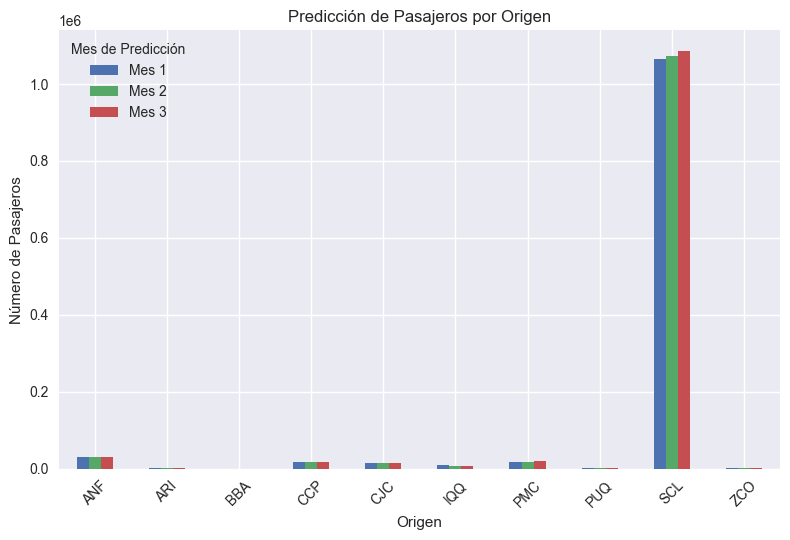

In [40]:
# Filtrar vuelos nacionales
vuelos_nacionales = df_salidas

# Obtener top 10 orígenes
top_10_origenes = vuelos_nacionales.groupby('ORIG_1')['PASAJEROS'].sum()\
    .sort_values(ascending=False).head(10)

print("Top 10 Orígenes Nacionales por Volumen de Pasajeros:")
print(top_10_origenes)

# Crear DataFrame para predicciones por origen
predicciones_origenes = []

for origen in top_10_origenes.index:
    # Filtrar datos para el origen específico
    df_origen = vuelos_nacionales[vuelos_nacionales['ORIG_1'] == origen]
    
    # Resto del código igual, solo cambiando 'aeropuerto' por 'origen'
    df_mensual_origen = df_origen.groupby(['Fecha'])['PASAJEROS'].sum().reset_index()
    
    # Crear características
    df_mensual_origen['Mes_Numero'] = df_mensual_origen.index + 1
    df_mensual_origen['Año'] = df_mensual_origen['Fecha'].dt.year
    df_mensual_origen['Mes'] = df_mensual_origen['Fecha'].dt.month
    df_mensual_origen['prev_month_passengers'] = df_mensual_origen['PASAJEROS'].shift(1)\
        .fillna(df_mensual_origen['PASAJEROS'].mean())
    df_mensual_origen['is_holiday'] = df_mensual_origen['Mes'].isin([7, 8, 12]).astype(int)
    df_mensual_origen['quarter'] = (df_mensual_origen['Mes'] - 1) // 3 + 1

        # Preparar features para el origen específico
    X = df_mensual_origen[[
        'Mes_Numero', 
        'Mes', 
        'Año', 
        'is_holiday',
        'quarter',
        'prev_month_passengers'
    ]]
    y = df_mensual_origen['PASAJEROS']

    # Normalizar datos
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Crear y entrenar modelo para este origen
    rf_model = RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        min_samples_split=5,
        random_state=42
    )
    rf_model.fit(X_scaled, y)

    # Preparar datos para predicción
    ultimo_mes = df_mensual_origen.iloc[-1]
    proximos_meses = []
    for i in range(1, 4):
        nuevo_mes = {
            'Mes_Numero': ultimo_mes['Mes_Numero'] + i,
            'Mes': ((ultimo_mes['Mes'] + i - 1) % 12) + 1,
            'Año': ultimo_mes['Año'] + ((ultimo_mes['Mes'] + i - 1) // 12),
            'is_holiday': ((ultimo_mes['Mes'] + i - 1) % 12) + 1 in [7, 8, 12],
            'quarter': (((ultimo_mes['Mes'] + i - 1) % 12) + 1 - 1) // 3 + 1,
            'prev_month_passengers': ultimo_mes['PASAJEROS']
        }
        proximos_meses.append(nuevo_mes)

    # Hacer predicciones
    X_pred = pd.DataFrame(proximos_meses)
    X_pred_scaled = scaler.transform(X_pred)
    predicciones = rf_model.predict(X_pred_scaled)
    
    # Guardar predicciones
    for mes, pred in enumerate(predicciones, 1):
        predicciones_origenes.append({
            'Origen': origen,
            'Mes': mes,
            'Prediccion': int(pred)
        })

# Crear DataFrame de predicciones y mostrar resultados
df_predicciones = pd.DataFrame(predicciones_origenes)
df_predicciones_pivot = df_predicciones.pivot(
    index='Origen', 
    columns='Mes', 
    values='Prediccion'
)
df_predicciones_pivot.columns = ['Mes 1', 'Mes 2', 'Mes 3']

print("\nPredicciones de Pasajeros para los Próximos 3 Meses por Origen:")
print(df_predicciones_pivot.round(0))

# Visualizar predicciones
plt.figure(figsize=(12, 6))
df_predicciones_pivot.plot(kind='bar')
plt.title('Predicción de Pasajeros por Origen')
plt.xlabel('Origen')
plt.ylabel('Número de Pasajeros')
plt.xticks(rotation=45)
plt.legend(title='Mes de Predicción')
plt.tight_layout()
plt.show()

Asignación de temporadas por mes:
Mes 1: Invierno
Mes 2: Invierno
Mes 3: Primavera
Mes 4: Primavera
Mes 5: Primavera
Mes 6: Verano
Mes 7: Verano
Mes 8: Verano
Mes 9: Otoño
Mes 10: Otoño
Mes 11: Otoño
Mes 12: Invierno

Distribución de predicciones por temporada antes del pivot:
Año   Temporada
2025  Invierno     10
      Otoño        30
      Primavera     1
      Verano       12
2026  Invierno     30
      Otoño        30
      Primavera    30
      Verano       30
2027  Invierno     20
      Primavera    29
      Verano       18
Name: Prediccion, dtype: int64

Columnas con valores NaN:
Año   Temporada
2025  Invierno     0
      Otoño        0
      Primavera    0
      Verano       0
2026  Invierno     0
      Otoño        0
      Primavera    0
      Verano       0
2027  Invierno     0
      Primavera    0
      Verano       0
dtype: int64

Predicciones de Pasajeros por Temporada (sin NaN):
Año           2025                                 2026                     \
Temporada Invier

<Figure size 1500x800 with 0 Axes>

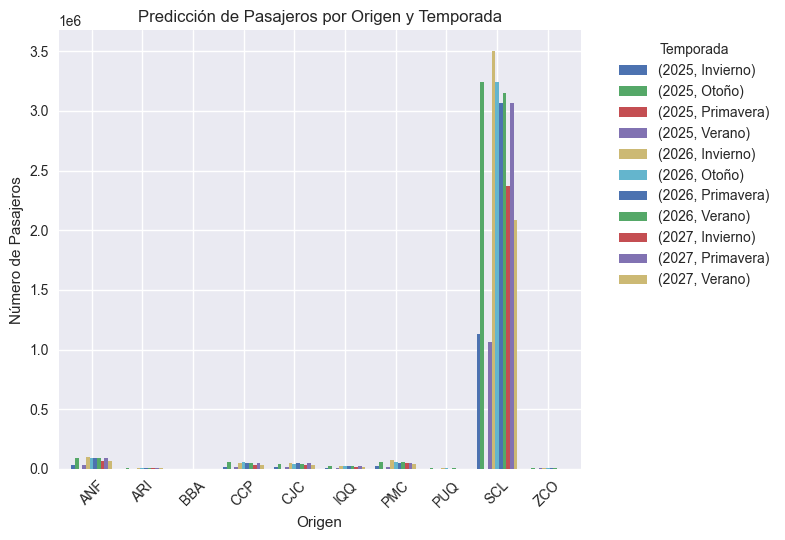

In [43]:
# Obtener top 10 orígenes y predicción por temporadas
vuelos_nacionales = df_salidas
top_10_origenes = vuelos_nacionales.groupby('ORIG_1')['PASAJEROS'].sum()\
    .sort_values(ascending=False).head(10)

predicciones_temporadas = []

# Verificar la asignación de temporadas
print("Asignación de temporadas por mes:")
for mes in range(1, 13):
    if mes in [12, 1, 2]:
        temp = 'Invierno'
    elif mes in [3, 4, 5]:
        temp = 'Primavera'
    elif mes in [6, 7, 8]:
        temp = 'Verano'
    else:
        temp = 'Otoño'
    print(f"Mes {mes}: {temp}")

for origen in top_10_origenes.index:
    # Filtrar datos para el origen específico
    df_origen = vuelos_nacionales[vuelos_nacionales['ORIG_1'] == origen]
    df_mensual_origen = df_origen.groupby(['Fecha', 'Temporada'])['PASAJEROS'].sum().reset_index()
    
    # Crear características
    df_mensual_origen['Mes_Numero'] = df_mensual_origen.index + 1
    df_mensual_origen['Año'] = df_mensual_origen['Fecha'].dt.year
    df_mensual_origen['Mes'] = df_mensual_origen['Fecha'].dt.month
    df_mensual_origen['prev_passengers'] = df_mensual_origen['PASAJEROS'].shift(1)\
        .fillna(df_mensual_origen['PASAJEROS'].mean())
    df_mensual_origen['is_holiday'] = df_mensual_origen['Mes'].isin([7, 8, 12]).astype(int)
    df_mensual_origen['quarter'] = (df_mensual_origen['Mes'] - 1) // 3 + 1

    # Preparar features
    X = df_mensual_origen[[
        'Mes_Numero', 'Mes', 'Año', 
        'is_holiday', 'quarter',
        'prev_passengers'
    ]]
    y = df_mensual_origen['PASAJEROS']

    # Normalizar y entrenar modelo
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
    rf_model.fit(X_scaled, y)

    # Preparar datos para predicción de 8 temporadas (2 años)
    ultimo_mes = df_mensual_origen.iloc[-1]
    proximas_temporadas = []
    for i in range(1, 25):  # 24 meses = 8 temporadas
        nuevo_mes = {
            'Mes_Numero': ultimo_mes['Mes_Numero'] + i,
            'Mes': ((ultimo_mes['Mes'] + i - 1) % 12) + 1,
            'Año': ultimo_mes['Año'] + ((ultimo_mes['Mes'] + i - 1) // 12),
            'is_holiday': ((ultimo_mes['Mes'] + i - 1) % 12) + 1 in [7, 8, 12],
            'quarter': (((ultimo_mes['Mes'] + i - 1) % 12) + 1 - 1) // 3 + 1,
            'prev_passengers': ultimo_mes['PASAJEROS']
        }
        proximas_temporadas.append(nuevo_mes)

    # Predecir
    X_pred = pd.DataFrame(proximas_temporadas)
    X_pred_scaled = scaler.transform(X_pred)
    predicciones = rf_model.predict(X_pred_scaled)
    
    # Asignar temporadas
    for i, pred in enumerate(predicciones):
        mes = ((ultimo_mes['Mes'] + i) % 12) + 1
        if mes in [12, 1, 2]:
            temporada = 'Invierno'
        elif mes in [3, 4, 5]:
            temporada = 'Primavera'
        elif mes in [6, 7, 8]:
            temporada = 'Verano'
        else:
            temporada = 'Otoño'
        
        predicciones_temporadas.append({
            'Origen': origen,
            'Temporada': temporada,
            'Año': ultimo_mes['Año'] + ((ultimo_mes['Mes'] + i) // 12),
            'Prediccion': int(pred)
        })

# Modificar la creación del DataFrame de predicciones
df_predicciones = pd.DataFrame(predicciones_temporadas)

# Verificar la distribución antes del pivot
print("\nDistribución de predicciones por temporada antes del pivot:")
print(df_predicciones.groupby(['Año', 'Temporada'])['Prediccion'].count())

# Crear pivot table con manejo explícito de NaN
df_predicciones_pivot = df_predicciones.pivot_table(
    index='Origen',
    columns=['Año', 'Temporada'],
    values='Prediccion',
    aggfunc='sum',
    fill_value=0  # Rellenar NaN con 0 inmediatamente
).round(0)

# Verificar si aún hay NaN
print("\nColumnas con valores NaN:")
print(df_predicciones_pivot.isna().sum())

# Si aún hay NaN, rellenarlos con la media de la temporada
if df_predicciones_pivot.isna().sum().sum() > 0:
    df_predicciones_pivot = df_predicciones_pivot.fillna(df_predicciones_pivot.mean())

print("\nPredicciones de Pasajeros por Temporada (sin NaN):")
print(df_predicciones_pivot)

# Visualizar predicciones
plt.figure(figsize=(15, 8))
df_predicciones_pivot.plot(kind='bar', width=0.8)
plt.title('Predicción de Pasajeros por Origen y Temporada')
plt.xlabel('Origen')
plt.ylabel('Número de Pasajeros')
plt.xticks(rotation=45)
plt.legend(title='Temporada', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()